# Imports and setup

In [1]:
# We can now load the dependencies
%matplotlib inline 
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
from tqdm import tqdm
import torch.optim as optim
import torchmetrics
import pandas as pd

# If VSCode doesn't pick up this import, see answer here: 
# https://stackoverflow.com/questions/65252074/import-path-to-own-script-could-not-be-resolved-pylance-reportmissingimports
import sys
sys.path.append("../../Datasets/")
from Custom_Dataset import * 

We can start by setting a seed for reproducibility

In [2]:
torch.manual_seed(0)

# Pre-processing

We start by defining a custom dataset which loads the data from disk lazily. This is because we have too many training examples to keep all of them in memory at once. The CustomDataset class is defined in Datasets/Cutsom_Dataset.py

In [3]:
# Extract the generated data
train_gen_dataset = CustomDataset("Generated", "train", balance = True)
val_gen_dataset = CustomDataset("Generated", "validation", balance=True)
test_gen_dataset = CustomDataset("Generated", "test", balance=True)

# Extract the real data
train_real_dataset = CustomDataset("Real Life", "train", balance=True)
val_real_dataset = CustomDataset("Real Life", "validation", balance=True)
test_real_dataset = CustomDataset("Real Life", "test", balance=True)

# Hyperparameter choices

We create a cell to hold the hyperparameters of the model

In [4]:
learning_rate = 0.001
batch_size_choices = {100, 200} # Each the real and generated data will be split into batches of this size (Since we only train on generated here)
num_epochs = 1 # Since we only train on generated data, we can use a small number of epochs because we have around 300000 images plus the augmentation
dropout_rate_choices = {0.2, 0.5}
gamma_focal_loss_choices = {2, 5} # Choices for the gamma parameter in the focal loss
n_validation = 10 # Number of iterations between each validation run
n_validation_minibatches = 2 # Number of minibatches to use for validation
n_final_validation_minibatches = 20 # Number of minibatches to use for the final validation run

# Model implementation

We can start by loading a pre-trained VGG16 model without the classification layers towards the end (Only the feature extractor).

In [5]:
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

We can now visualize its layers:

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Because we are looking for a pre-trained feature extractor here, we decide to only use the features part and freeze its weights. We can then add a few subsequent layers to fine tune predictions. We can thus define the following model:

In [7]:
class BaseModel(nn.Module):

    def __init__(self, num_classes=13, dropout_rate=0.5):
        
        super(BaseModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        # Set the features to not require gradients
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Training

We can start by finding the device to use for training:

In [8]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.has_mps:
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

if DEVICE == "cuda":
    torch.cuda.empty_cache()

print("Device:", DEVICE)

Device: cuda


We can then go ahead and define the loss function we will be using. Because we will opt for a balanced focal loss instead of a regular cross entropy loss which gives more importance to the classes that are harder to classify. We thus implement the focal loss defined by the following formula:
$$
FL(p_t) = -(1-p_t^{\gamma})log(p_t)
$$

where gamma $\gamma$ is a tunable hyperparameter. We can also further add an alpha term to handle class imbalance, making our loss function a class-balanced focal loss, as shown in https://github.com/AdeelH/pytorch-multi-class-focal-loss. 
Note: Since we have balanced classes thanks to oversmapling, we will not use the alpha parameter.



Finally, we need an accuracy metric to tune the hyperparameters of the model. We will opt for a balanced accuracy score, which is just regular classification accuracy but adapted to weigh each class by its frequency:

In [9]:
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=13, average="weighted").to(DEVICE)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

We can now load a single example from the loader and display its label as well as its class proportion, which should be around 1/13 which is +- 8%.

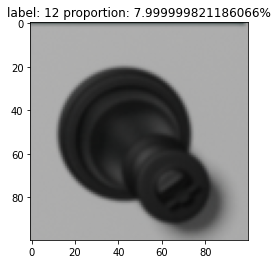

In [33]:
gen_train_loader = get_loader(train_gen_dataset, batch_size=200)

for i, (images, labels) in enumerate(gen_train_loader):
    class_proportions = [(labels == i).sum() / len(labels) for i in range(13)]
    plt.title("label: " + str(labels[0].item()) + " proportion: " + str(class_proportions[labels[0].item()].item() * 100) + "%")
    plt.imshow(images[0].permute(1, 2, 0))
    break

We can also define the following function for plotting the metrics collected during training:

In [11]:
def plot_and_save_metrics(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate):

    validation_x_axis = np.arange(0, len(gen_validation_losses) * n_validation, n_validation)

    plt.figure(figsize=(30, 30))

    plt.subplot(3, 2, 1)
    plt.plot(gen_training_losses)
    plt.title("Training Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")

    plt.subplot(3, 2, 2)
    plt.plot(gen_training_accs)
    plt.title("Training Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")

    plt.subplot(3, 2, 3)
    plt.plot(gen_training_f1s)
    plt.title("Training weighted F1 scores")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted F1 score")

    plt.subplot(3, 2, 4)
    plt.plot(validation_x_axis, gen_validation_losses, label="Source domain")
    plt.plot(validation_x_axis, real_validation_losses, label="Target domain")
    plt.title("Validation Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Focal loss")
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(validation_x_axis, gen_validation_accs, label="Source domain")
    plt.plot(validation_x_axis, real_validation_accs, label="Target domain")
    plt.title("Validation Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.plot(validation_x_axis, gen_validation_f1s, label="Source domain")
    plt.plot(validation_x_axis, real_validation_f1s, label="Target domain")
    plt.title("Validation weighted F1 Scores")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted F1 Score")
    plt.legend()

    plt.suptitle("Hyperparameters: gamma: " + str(gamma) + ", batch_size: " + str(batch_size) + ", dropout_rate: " + str(dropout_rate), fontsize=24)
    
    plt.savefig("HP tuning results/" + "gamma_" + str(gamma) + "_batch_" + str(batch_size) + "_dropout_" + str(dropout_rate) + ".png",  facecolor='white', transparent=False)
    plt.close()

We can now proceed to train our model:

In [12]:
# To store the best model
best_model = None
best_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Gamma", "Batch size", "Dropout rate", "Final validation accuracy"])

for gamma in gamma_focal_loss_choices:

    for dropout_rate in dropout_rate_choices:

        for batch_size in batch_size_choices:

            # Define the data loaders accounting for the batch size
            gen_train_loader = get_gen_loader(train_gen_dataset, batch_size=batch_size)
            gen_val_loader = get_gen_loader(val_gen_dataset, batch_size=batch_size)
            gen_test_loader = get_gen_loader(test_gen_dataset, batch_size=batch_size)
            real_train_loader = get_real_loader(train_real_dataset, batch_size=batch_size)
            real_val_loader = get_real_loader(val_real_dataset, batch_size=batch_size)
            real_test_loader = get_real_loader(test_real_dataset, batch_size=batch_size)

            # Define the new loss function (Taking into account gamma)
            focal_loss = torch.hub.load(
                'adeelh/pytorch-multi-class-focal-loss',
                model='FocalLoss',
                gamma=gamma, # No use of alpha since we have balanced classes now with the oversampling
                reduction='mean',
                force_reload=False,
                verbose = False
            ).to(DEVICE)

            # To store the metrics through epochs
            gen_training_losses = []
            gen_training_accs = []
            gen_training_f1s = []
            gen_validation_losses = []
            gen_validation_accs = []
            gen_validation_f1s = []
            real_validation_losses = []
            real_validation_accs = []
            real_validation_f1s = []

            # Define the model and the optimizer
            basemodel = BaseModel(dropout_rate=dropout_rate).to(DEVICE)
            opt = optim.Adam(basemodel.parameters(), lr=learning_rate)
            
            for epoch in range(num_epochs):
                
                # Train the model
                for iteration, (X_train_gen, y_train_gen) in tqdm(enumerate(gen_train_loader)):
                    
                    # Set the model to training mode
                    basemodel.train()

                    # Move the data to the device
                    X_train_gen = X_train_gen.to(DEVICE)
                    y_train_gen = y_train_gen.to(DEVICE)

                    # Forward pass
                    y_train_pred_raw_gen = basemodel(X_train_gen)
                    y_train_pred_gen = torch.argmax(y_train_pred_raw_gen, dim=1)

                    # Compute the loss
                    loss_train = focal_loss(y_train_pred_raw_gen, y_train_gen.long())

                    # Compute the accuracy
                    acc_train = accuracy(y_train_pred_gen, y_train_gen)
                    f1_train = f1_score(y_train_pred_gen, y_train_gen)

                    # Backward pass
                    opt.zero_grad()
                    loss_train.backward()
                    opt.step()

                    # Store the loss & accuracy
                    gen_training_losses.append(loss_train.item())
                    gen_training_accs.append(acc_train.item())
                    gen_training_f1s.append(f1_train.item())
                    
                    # Check if the model should be validated
                    if iteration == 0 or (iteration + 1) % n_validation == 0:
                        
                        # Set the model to evaluation mode
                        basemodel.eval()
                        
                        # Disable gradient calculation
                        with torch.no_grad():

                            # 1) Evaluate on the generated validation set
                            acc_val_sum = 0
                            weighted_f1_val_sum = 0
                            loss_val_sum = 0

                            # Extract an iterator from the generated data loader
                            gen_val_iter = iter(gen_val_loader)

                            # Iterate for n_validation_minibatches
                            for i in range(n_validation_minibatches):

                                # Get the next minibatch
                                X_val_gen, y_val_gen = next(gen_val_iter)
                                    
                                # Move the data to the device
                                X_val_gen = X_val_gen.to(DEVICE)
                                y_val_gen = y_val_gen.to(DEVICE)

                                # Forward pass
                                y_val_pred_raw_gen = basemodel(X_val_gen)
                                y_val_pred_gen = torch.argmax(y_val_pred_raw_gen, dim=1)

                                # Compute the metrics
                                acc_val_sum += accuracy(y_val_pred_gen, y_val_gen)
                                weighted_f1_val_sum += f1_score(y_val_pred_gen, y_val_gen)
                                loss_val_sum += focal_loss(y_val_pred_raw_gen, y_val_gen)

                            # Compute the average metrics
                            acc_val_gen = acc_val_sum / n_validation_minibatches
                            loss_val_gen = loss_val_sum / n_validation_minibatches
                            weighted_f1_val_gen = weighted_f1_val_sum / n_validation_minibatches

                            # 2) Repeat on the real validation set
                            acc_val_sum = 0
                            weighted_f1_val_sum = 0
                            loss_val_sum = 0

                            # Extract an iterator from the generated data loader
                            real_val_iter = iter(real_val_loader)

                            # Iterate for n_validation_minibatches
                            for i in range(n_validation_minibatches):

                                # Get the next minibatch
                                X_val_real, y_val_real = next(real_val_iter)
                                    
                                # Move the data to the device
                                X_val_real = X_val_real.to(DEVICE)
                                y_val_real = y_val_real.to(DEVICE)

                                # Forward pass
                                y_val_pred_raw_real = basemodel(X_val_real)
                                y_val_pred_real = torch.argmax(y_val_pred_raw_real, dim=1)

                                # Compute the metrics
                                acc_val_sum += accuracy(y_val_pred_real, y_val_real)
                                weighted_f1_val_sum += f1_score(y_val_pred_real, y_val_real)
                                loss_val_sum += focal_loss(y_val_pred_raw_real, y_val_real)

                            # Compute the average metrics
                            acc_val_real = acc_val_sum / n_validation_minibatches
                            loss_val_real = loss_val_sum / n_validation_minibatches
                            weighted_f1_val_real = weighted_f1_val_sum / n_validation_minibatches

                            # Store all 6 metrics
                            gen_validation_losses.append(loss_val_gen.item())
                            gen_validation_accs.append(acc_val_gen.item())
                            gen_validation_f1s.append(weighted_f1_val_gen.item())
                            real_validation_losses.append(loss_val_real.item())
                            real_validation_accs.append(acc_val_real.item())
                            real_validation_f1s.append(weighted_f1_val_real.item())

                            # Print an update
                            print('----------------------------------------------------------------')
                            print(f'EPOCH [{epoch + 1}], ITERATION [{iteration+1}]')
                            print(f'TRAINING => Loss: {loss_train}, Training accuracy: {acc_train}, Training weighted F1: {f1_train}')
                            print(f'GENERATED VALIDATION => Loss: {loss_val_gen}, Validation accuracy: {acc_val_gen}, Validation weighted F1: {weighted_f1_val_gen}')
                            print(f'REAL VALIDATION => Loss: {loss_val_real}, Validation accuracy: {acc_val_real}, Validation weighted F1: {weighted_f1_val_real}')
                            print('----------------------------------------------------------------')

                # Save the model every epoch as a checkpoint 
                torch.save(basemodel.state_dict(), f'./checkpoints/basemodel_gamma_{gamma}_dropout_{dropout_rate}_batch_{batch_size}_epoch_{epoch+1}.ckpt')


            # Evaluate the final real life validation accuracy

            # Set the model to evaluation mode
            basemodel.eval()
            acc_val_sum = 0

            # Create an iterator
            real_val_iter = iter(real_val_loader)

            # Disable gradient calculation
            with torch.no_grad():
                
                for i in range(n_final_validation_minibatches):

                    # Get the next minibatch
                    minibatch = next(real_val_iter, None)
                    if minibatch is None:
                        real_val_iter = iter(real_val_loader)
                        minibatch = next(real_val_iter, None)
                    X_val_real, y_val_real = minibatch

                    # Move the data to the device
                    X_val_real = X_val_real.to(DEVICE)
                    y_val_real = y_val_real.to(DEVICE)

                    # Forward pass
                    y_val_pred_prob_real = basemodel(X_val_real)
                    y_val_pred_real = torch.argmax(y_val_pred_prob_real, dim=1)

                    # Compute the metrics
                    acc_val_sum += accuracy(y_val_pred_real, y_val_real)

            # Compute the average accuracy
            final_real_val_acc = acc_val_sum / n_final_validation_minibatches

            # Create a row to add to the dataframe
            row = [gamma, batch_size, dropout_rate, final_real_val_acc.cpu().item()]

            # Store it
            hp_final_accs.loc[len(hp_final_accs)] = row

            # Compare to the best model
            if best_model is None or best_acc < final_real_val_acc:
                best_model = basemodel
                best_acc = final_real_val_acc
                torch.save(basemodel.state_dict(), f'./best_model.ckpt')

            # Plot and save the metrics
            plot_and_save_metrics(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate)

# Save the dataframe as a table
hp_final_accs.to_csv('HP_final_accuracies.csv', index=False)


NameError: name 'get_gen_loader' is not defined

After this code runs, the best model can be found in the directory of the script.